# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from matplotlib import pyplot
import seaborn as sns

import numpy as np

from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import pickle


In [53]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# load SQLite
id = '1VDFn9tpwO0ecnr5DiC7TQwg-GVoPJUEK'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('database.sqlite')  

# df2 = pd.read_csv(io.BytesIO(uploaded['Filename.csv']))

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [23]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[18]

100%|██████████| 87773/87773 [00:39<00:00, 2224.95it/s]


'could rate fly trap lower one star would think flies come miles away come laugh thing would success taking flies vat scalding water getting fly randomly run box ridiculousness waste'

## [3.2] Preprocessing Review Summary

In [24]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[18]

100%|██████████| 87773/87773 [00:28<00:00, 3124.85it/s]


'day zero flies'

# [4] Featurization

## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10, use_idf=True)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'abroad', 'absence']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 11524)
the number of unique words including both unigrams and bigrams  11524


# [5] Assignment 11: Truncated SVD

In [0]:
K = list(range(2, 13, 2))

def finding_best_k(X_tr):

  train_ =[]
  
  for i in K:
      tr_kmeans = KMeans(n_clusters=i,verbose=1)
      tr_kmeans.fit(X_tr)

      train_inertia =  tr_kmeans.inertia_

      train_.append(train_inertia)
  return train_

def plotErrorplot(train_):
  plt.plot(K, train_, label='Train AUC')
  plt.legend()
  plt.xlabel("K: hyperparameter")
  plt.ylabel("Inertia")
  plt.grid()
  plt.title("ERROR PLOTS")
  plt.show()
  
  
# fetch result from dataframe, where matchlabel== expected label, finally convert to string
def returnWordCloudString(df, matchlabel):
    return df['Features'][df.label == matchlabel].to_string()
  
  
def plotWordCloud(text):

  #  https://www.geeksforgeeks.org/generating-word-cloud-python/

  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='black', 
                  min_font_size = 10).generate(text) 

  # plot the WordCloud image                        
  plt.figure(figsize = (10, 10), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  plt.show()

## Truncated-SVD

### [5.1] Taking top features from TFIDF

In [29]:
top_words_freq =tf_idf_vect.idf_
print(top_words_freq.shape)

top_word_count = 2000

features = tf_idf_vect.get_feature_names()

top_df = pd.DataFrame({'Features' : features, 'Idf_score' : top_words_freq})
top_df = top_df.sort_values("Idf_score", ascending = True)[:top_word_count]
print("shape of selected features :", top_df.shape)

top2000 = top_df['Features'][:2000]


(11524,)
shape of selected features : (2000, 2)


### [5.2] Calulation of Co-occurrence matrix

In [35]:
# https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix?noredirect=1&lq=1
# https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/TruncatedSvd__amazon_food_review.ipynb
# https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285
# https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/


co_occurence_matrix = np.zeros((len(top_df), len(top_df)))
preprocess_review_df = pd.DataFrame(co_occurence_matrix, index = top_df["Features"], columns = top_df["Features"])

window_size = 6
for sent in tqdm(final["preprocessed_reviews"]):
    word = sent.split(" ")
    for i, d in enumerate(word):
        for j in range(max(i - window_size, 0), min(i + window_size, len(word))):
            if (word[i] != word[j]):
                    try:
                        preprocess_review_df.loc[word[i], word[j]] += 1
                    except:
                        pass



100%|██████████| 87773/87773 [2:48:11<00:00,  8.70it/s]


In [0]:
import pickle
output = open('trunctSVD.pkl', 'wb')
pickle.dump(preprocess_review_df,output)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  
folder_id = '1WSEkuSi3HSyJ_4v0UH_JdyTZRQmeqHdj'
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('trunctSVD.pkl')
file.Upload() 

In [38]:
preprocess_review_df.head()

Features,not,like,good,great,one,taste,would,product,love,flavor,get,no,really,much,amazon,time,also,best,buy,coffee,little,price,tried,use,even,find,well,make,food,try,better,eat,first,could,tea,found,used,bought,made,way,...,mellow,muffins,assume,active,dough,consumption,stored,kashi,hershey,didnt,labels,receiving,shrimp,america,loving,showed,mill,necessary,mainly,volume,fussy,spoiled,tons,childhood,suspect,crap,lately,owners,watered,kraft,automatic,appear,palate,penny,swallow,fries,email,allowed,kiwi,eaters
Features,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
not,0.0,15880.0,9529.0,5361.0,7085.0,10644.0,9162.0,6210.0,3882.0,7307.0,5480.0,3217.0,5465.0,5399.0,3283.0,3033.0,3253.0,2320.0,3953.0,6674.0,2722.0,2779.0,3410.0,3179.0,4629.0,3778.0,2854.0,3043.0,4901.0,2904.0,2503.0,4339.0,2236.0,4725.0,4724.0,1943.0,1870.0,1508.0,1885.0,1798.0,...,71.0,65.0,80.0,44.0,68.0,61.0,80.0,52.0,83.0,32.0,74.0,53.0,42.0,53.0,44.0,45.0,57.0,101.0,50.0,72.0,83.0,53.0,65.0,40.0,88.0,83.0,60.0,49.0,110.0,61.0,29.0,88.0,76.0,37.0,87.0,42.0,72.0,83.0,94.0,79.0
like,15934.0,0.0,3532.0,2112.0,2873.0,6493.0,3410.0,2038.0,1719.0,3381.0,1566.0,1653.0,3499.0,2117.0,733.0,943.0,1749.0,1092.0,1026.0,4014.0,1632.0,694.0,1350.0,1153.0,1399.0,903.0,1085.0,1187.0,1934.0,1368.0,1285.0,1137.0,913.0,697.0,2570.0,607.0,773.0,554.0,774.0,828.0,...,23.0,39.0,19.0,10.0,46.0,18.0,23.0,42.0,53.0,61.0,16.0,12.0,37.0,19.0,18.0,9.0,24.0,17.0,25.0,19.0,13.0,27.0,21.0,26.0,17.0,60.0,17.0,15.0,67.0,36.0,22.0,29.0,24.0,10.0,28.0,38.0,7.0,14.0,54.0,29.0
good,9549.0,3525.0,0.0,1932.0,2123.0,4103.0,2256.0,2390.0,1380.0,2728.0,1357.0,1242.0,2908.0,1020.0,1024.0,946.0,1567.0,818.0,1113.0,2853.0,1106.0,2198.0,917.0,938.0,991.0,944.0,1042.0,1069.0,1389.0,899.0,988.0,958.0,567.0,646.0,1959.0,643.0,552.0,557.0,705.0,727.0,...,24.0,32.0,18.0,12.0,22.0,11.0,16.0,26.0,23.0,27.0,9.0,8.0,20.0,13.0,18.0,11.0,23.0,14.0,12.0,15.0,17.0,16.0,24.0,18.0,16.0,22.0,21.0,9.0,21.0,26.0,18.0,16.0,12.0,6.0,19.0,37.0,11.0,10.0,26.0,16.0
great,5386.0,2109.0,1914.0,0.0,1393.0,3320.0,1427.0,3233.0,1847.0,2485.0,1120.0,1119.0,1294.0,804.0,1279.0,894.0,1342.0,697.0,963.0,2346.0,963.0,2409.0,543.0,1057.0,759.0,851.0,865.0,1094.0,1041.0,590.0,598.0,628.0,415.0,409.0,1566.0,475.0,520.0,398.0,482.0,787.0,...,26.0,42.0,9.0,18.0,13.0,5.0,7.0,25.0,12.0,9.0,9.0,15.0,23.0,10.0,18.0,8.0,9.0,8.0,12.0,9.0,12.0,7.0,20.0,14.0,7.0,7.0,8.0,13.0,13.0,12.0,17.0,9.0,6.0,9.0,8.0,33.0,5.0,11.0,11.0,13.0
one,7012.0,2904.0,2134.0,1380.0,0.0,1582.0,1915.0,1109.0,1278.0,1510.0,1358.0,1379.0,1069.0,908.0,789.0,1305.0,867.0,1550.0,859.0,1791.0,911.0,632.0,1505.0,882.0,842.0,814.0,700.0,857.0,1198.0,1143.0,790.0,1342.0,809.0,758.0,1379.0,711.0,520.0,674.0,524.0,496.0,...,17.0,10.0,20.0,12.0,7.0,13.0,12.0,29.0,13.0,12.0,24.0,15.0,19.0,9.0,18.0,20.0,13.0,10.0,16.0,17.0,32.0,15.0,9.0,22.0,22.0,11.0,20.0,10.0,15.0,20.0,12.0,12.0,16.0,11.0,23.0,7.0,9.0,18.0,16.0,18.0


In [0]:
top2000 = []

for col in preprocess_review_df.columns: 
    top2000.append(col) 

### [5.3] Finding optimal value for number of components (n) to be retained.

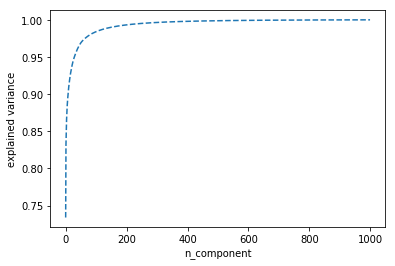

In [40]:
# TrucatedSVD

tsvd = TruncatedSVD(n_components = 1000)
ts_data = tsvd.fit_transform(preprocess_review_df)

var_explained = tsvd.explained_variance_ / np.sum(tsvd.explained_variance_)

cum_var_explained = np.cumsum(var_explained) 

plt.plot(cum_var_explained,"--")
plt.xlabel('n_component')
plt.ylabel('explained variance')
plt.show()

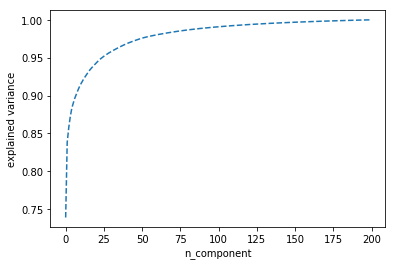

In [41]:
# TrucatedSVD

tsvd = TruncatedSVD(n_components = 200)
ts_data = tsvd.fit_transform(preprocess_review_df)

var_explained = tsvd.explained_variance_ / np.sum(tsvd.explained_variance_)

cum_var_explained = np.cumsum(var_explained) 

plt.plot(cum_var_explained,"--")
plt.xlabel('n_component')
plt.ylabel('explained variance')
plt.show()

From above graph, it can observe that only 90 components can explain almost 99% of variance. 



In [0]:
# TrucatedSVD

tsvd = TruncatedSVD(n_components = 90)
ts_data = tsvd.fit_transform(preprocess_review_df)

var_explained = tsvd.explained_variance_ / np.sum(tsvd.explained_variance_)

cum_var_explained = np.cumsum(var_explained) 


### [5.4] Applying k-means clustering

In [0]:
bow_train = finding_best_k(ts_data)

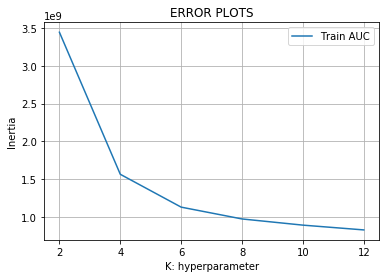

In [44]:
plotErrorplot(bow_train)

In [45]:
kmeans = KMeans(n_clusters=6, n_jobs=-1).fit(ts_data)
labels = kmeans.labels_

no_of_clusters = set(labels.flatten())
no_of_clusters

{0, 1, 2, 3, 4, 5}

In [0]:
# create duplicate copy of original dataframe as final2
preprocess_review_df2 = preprocess_review_df.copy()

# adding this labels result to duplicate copy dataframe
preprocess_review_df2['label']= labels

preprocess_review_df2['Features'] = top_df['Features']

# remove nan
preprocess_review_df2 = preprocess_review_df2.replace(np.nan, '', regex=True)


# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(preprocess_review_df2,0)

# fetch reviews, those label==1, also convert to string
cluster_1 = returnWordCloudString(preprocess_review_df2,1)

# fetch reviews, those label==2, also convert to string
cluster_2 = returnWordCloudString(preprocess_review_df2,2)

# fetch reviews, those label==3, also convert to string
cluster_3 = returnWordCloudString(preprocess_review_df2,3)

# fetch reviews, those label==4, also convert to string
cluster_4 = returnWordCloudString(preprocess_review_df2,4)

# fetch reviews, those label==5, also convert to string
cluster_5 = returnWordCloudString(preprocess_review_df2,5)

cluster_list = [cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5]

### [5.5] Wordclouds of clusters obtained in the above section

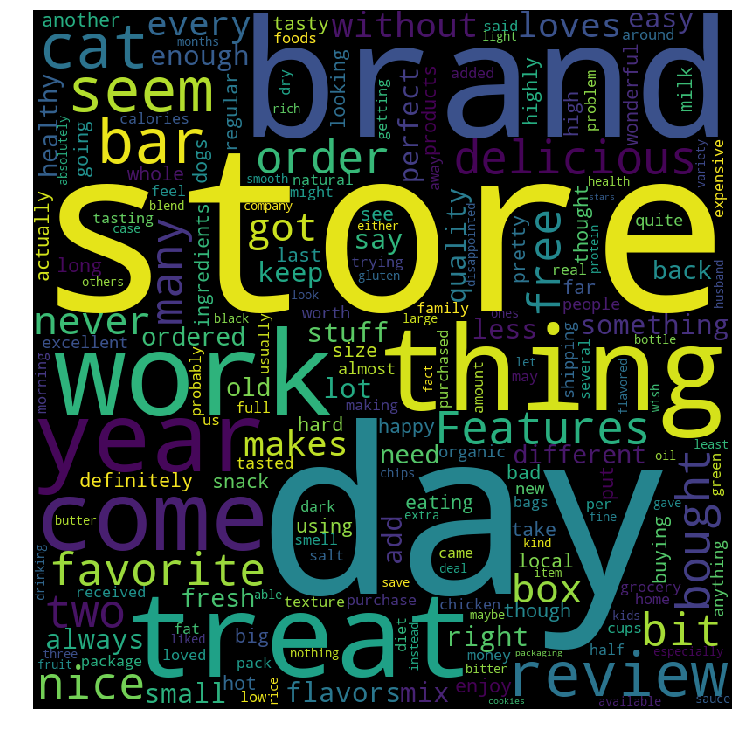

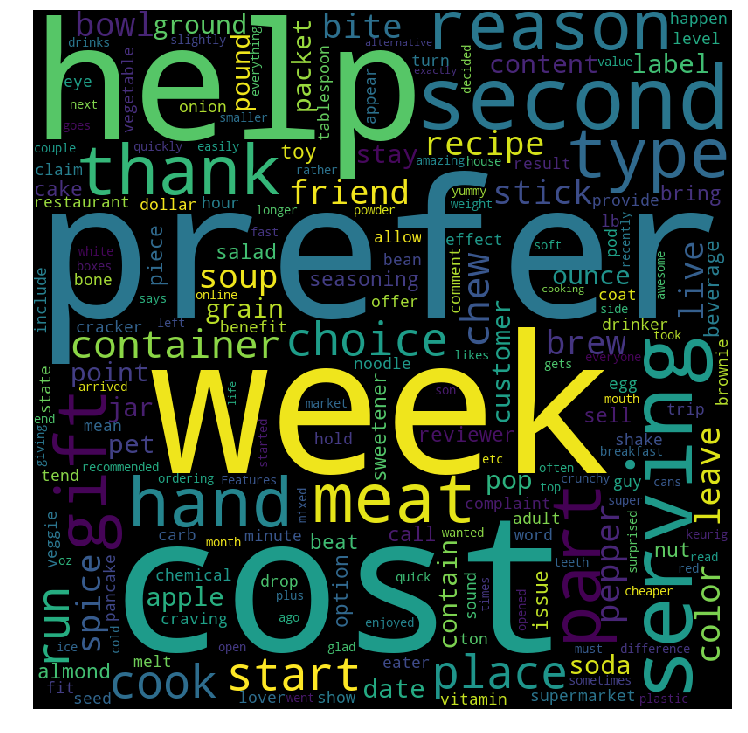

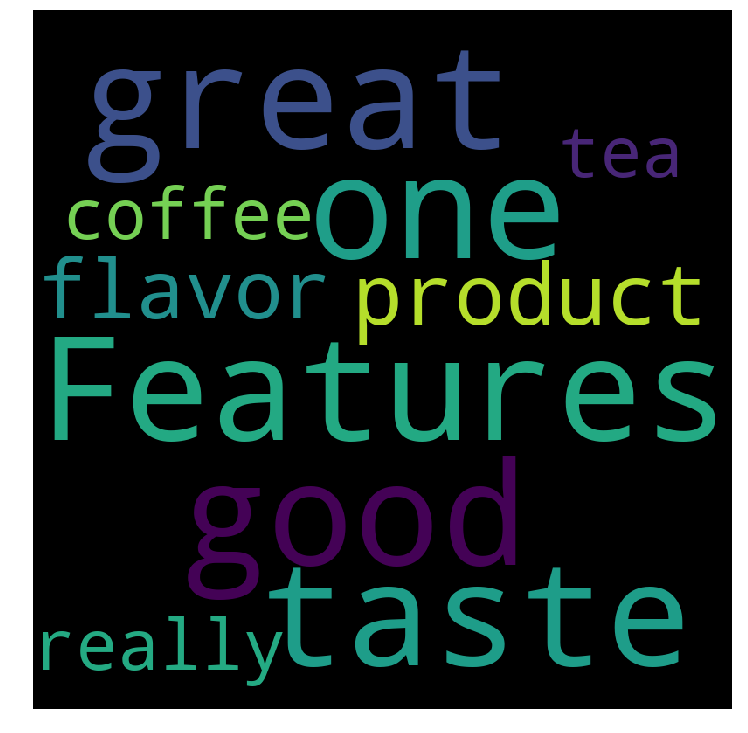

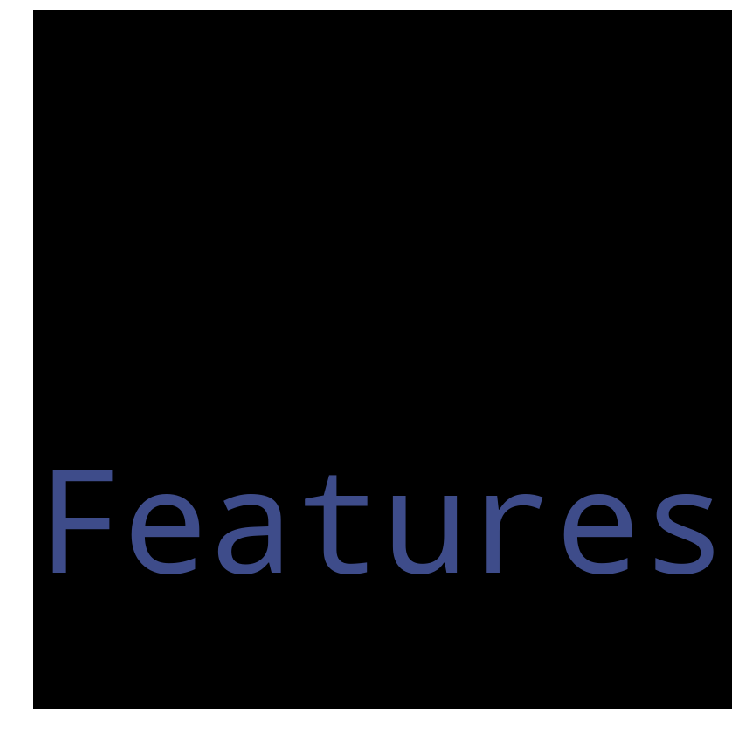

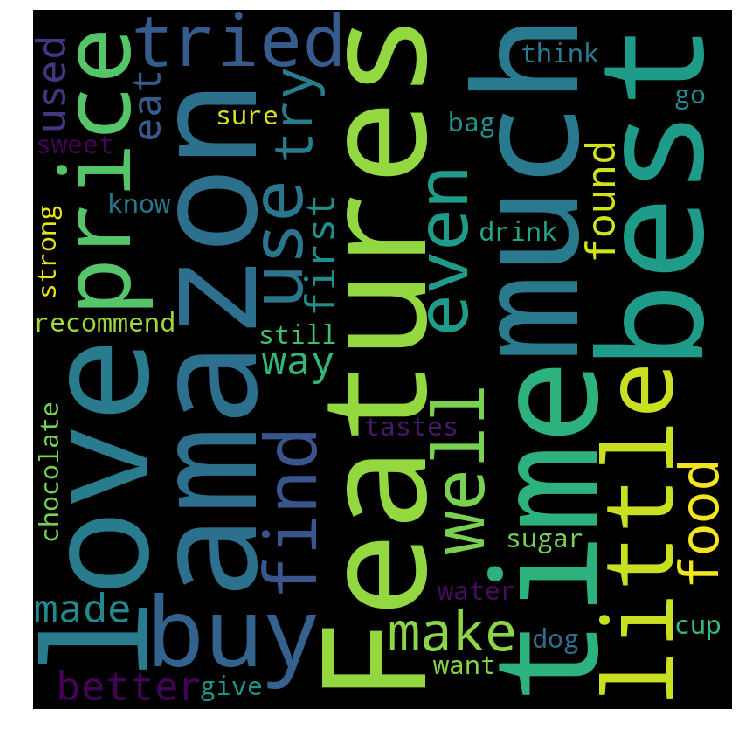

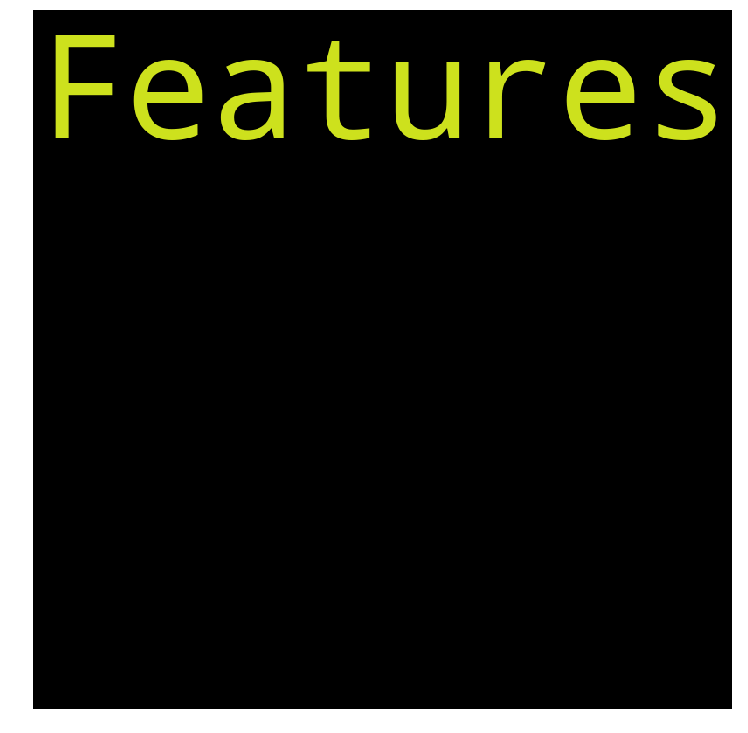

In [47]:
for i in cluster_list:
    plotWordCloud(i)

### [5.6] Function that returns most similar words for a given word.

In [0]:
# https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

def findSimilaryWords(word):
  
  # find the index of word
  ind = top2000.index(word)

  # cosine similarity
  cos_similarity = cosine_similarity(ts_data)
  sim_vect_ = cos_similarity[ind]
  index = sim_vect_.argsort()[::-1][1:10]

  for j in range(len(index)):
      print((j+1),top2000[index[j]] ,"===",word,"\n")

In [49]:
findSimilaryWords('calories')

1 fiber === calories 

2 low === calories 

3 sodium === calories 

4 content === calories 

5 protein === calories 

6 carbs === calories 

7 iron === calories 

8 total === calories 

9 reduced === calories 



In [50]:
findSimilaryWords('cheaper')

1 prices === cheaper 

2 target === cheaper 

3 walmart === cheaper 

4 bulk === cheaper 

5 sale === cheaper 

6 costs === cheaper 

7 selling === cheaper 

8 sells === cheaper 

9 cost === cheaper 



In [51]:
findSimilaryWords('good')

1 amazing === good 

2 fine === good 

3 however === good 

4 awesome === good 

5 course === good 

6 ok === good 

7 type === good 

8 appreciate === good 

9 totally === good 



# [6] Conclusions

### Procedure

* We have consider '100k' datapoints for this experiement.
* Firstly took TFIDF weighted vector and find "top 2000" feature using idf_ (**The inverse document frequency vector**)
* Then build Co-Occurance matrix, which have 2000*2000 dimension.
* Then find optimal n_component value using 'elbow' method. we found **n_component = 90**
* Applied this Top feature to KMean algorithm and build cluster. While applying Kmean,firstly hyperparam tune and find number of cluster require again using 'elbow' method, we found **no_clusters = 6**
* plot word cloud on basis of clusters build by Kmean algorithm
* Using Cosine Similarity create function which will return most similar word from given corpus










